# Character Extraction and Normalization

This notebook extracts individual characters from CAPTCHA images based on YOLO format bounding box annotations and normalizes them to a uniform size.

## Workflow:
1. Read YOLO format label files from label directories
2. Extract character labels from filenames (e.g., `0a1gfi-0.txt` to `['0','a','1','g','f','i']`)
3. Crop character regions from original CAPTCHA images
4. Resize all characters to 32x32 RGB
5. Save to category folders (36 folders: 0-9, a-z)
6. Process both training and test datasets using the same pipeline

## Output:
- `train_characters/` - Training character samples (36 classes)
- `test_characters/` - Test character samples (36 classes)

## Import Libraries

In [22]:
import os
import cv2
import numpy as np
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

## Configuration

In [23]:
# Project root
PROJECT_ROOT = Path('..')

# Normalization parameters
TARGET_SIZE = (32, 32)  # Width x Height
KEEP_RGB = True  # Keep color channels (not grayscale)

# Define 36 character classes (0-9, a-z)
CHARACTERS = [str(i) for i in range(10)] + [chr(i) for i in range(ord('a'), ord('z') + 1)]

# Dataset configurations (train and test)
DATASETS = {
    # 'train': {
    #     'images_dir': PROJECT_ROOT / 'dataset' / 'train',
    #     'labels_dir': PROJECT_ROOT / 'Segmented_dataset' / 'train_labels',
    #     'output_dir': PROJECT_ROOT / 'Segmented_dataset' / 'train_characters'
    # },
    'test': {
        'images_dir': PROJECT_ROOT / 'dataset' / 'test',
        'labels_dir': PROJECT_ROOT / 'Segmented_dataset' / 'test_labels',
        'output_dir': PROJECT_ROOT / 'Segmented_dataset' / 'test_characters'
    }
}

print(f"Configuration:")
print(f"  Target Size: {TARGET_SIZE}")
print(f"  Character Classes: {len(CHARACTERS)}")
print(f"\nDatasets to process:")
for name, paths in DATASETS.items():
    print(f"  {name.upper()}:")
    print(f"    Images: {paths['images_dir']}")
    print(f"    Labels: {paths['labels_dir']}")
    print(f"    Output: {paths['output_dir']}")

Configuration:
  Target Size: (32, 32)
  Character Classes: 36

Datasets to process:
  TEST:
    Images: ..\dataset\test
    Labels: ..\Segmented_dataset\test_labels
    Output: ..\Segmented_dataset\test_characters


## Helper Functions

In [24]:
def parse_filename_to_labels(filename):
    """Extract character labels from filename."""
    base_name = filename.replace('.txt', '').replace('.png', '')
    if '-' in base_name:
        base_name = base_name.split('-')[0]
    labels = list(base_name.lower())
    return labels

def read_yolo_labels(label_path):
    """Read YOLO format labels from file."""
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            values = line.strip().split()
            if len(values) == 5:
                boxes.append([int(values[0]), float(values[1]), float(values[2]), 
                            float(values[3]), float(values[4])])
    return boxes

def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    """Convert YOLO normalized coordinates to pixel bounding box."""
    x_min = max(0, int((x_center - width / 2) * img_width))
    y_min = max(0, int((y_center - height / 2) * img_height))
    x_max = min(img_width, int((x_center + width / 2) * img_width))
    y_max = min(img_height, int((y_center + height / 2) * img_height))
    return x_min, y_min, x_max, y_max

def resize_with_padding(image, target_size, keep_rgb=True):
    """Resize image to target size while maintaining aspect ratio."""
    target_w, target_h = target_size
    h, w = image.shape[:2]
    
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    if keep_rgb and len(image.shape) == 3:
        padded = np.ones((target_h, target_w, 3), dtype=np.uint8) * 255
    else:
        padded = np.ones((target_h, target_w), dtype=np.uint8) * 255
    
    y_offset, x_offset = (target_h - new_h) // 2, (target_w - new_w) // 2
    padded[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    return padded

print("✓ Helper functions defined")

✓ Helper functions defined


## Main Extraction Function

In [25]:
def extract_characters(images_dir, labels_dir, output_dir, dataset_name, characters, target_size, keep_rgb):
    """
    Extract and normalize characters from CAPTCHA images.
    Returns: dict with counters, total extracted, and errors
    """
    print(f"\n{'='*70}")
    print(f"Processing {dataset_name.upper()}")
    print(f"{'='*70}\n")
    
    # Create output directories
    output_dir.mkdir(parents=True, exist_ok=True)
    for char in characters:
        (output_dir / char).mkdir(exist_ok=True)
    print(f"✓ Created {len(characters)} category folders\n")
    
    # Initialize counters
    character_counters = {char: 0 for char in characters}
    total_extracted = 0
    errors = []
    
    # Get all label files
    label_files = sorted(list(labels_dir.glob('*.txt')))
    print(f"Found {len(label_files)} label files\n")
    
    # Process each label file
    for label_file in tqdm(label_files, desc=f"Extracting {dataset_name}"):
        try:
            img_path = images_dir / (label_file.stem + '.png')
            if not img_path.exists():
                errors.append(f"Image not found: {img_path}")
                continue
            
            img = cv2.imread(str(img_path))
            if img is None:
                errors.append(f"Failed to read: {img_path}")
                continue
            
            img_height, img_width = img.shape[:2]
            char_labels = parse_filename_to_labels(label_file.name)
            boxes = read_yolo_labels(label_file)
            
            if len(boxes) != len(char_labels):
                errors.append(f"Mismatch: {label_file.name} has {len(boxes)} boxes but {len(char_labels)} chars")
                continue
            
            for i, (box, label) in enumerate(zip(boxes, char_labels)):
                _, x_center, y_center, width, height = box
                x_min, y_min, x_max, y_max = yolo_to_bbox(
                    x_center, y_center, width, height, img_width, img_height)
                
                char_img = img[y_min:y_max, x_min:x_max]
                if char_img.size == 0:
                    errors.append(f"Invalid crop: {label_file.name}, char {i}")
                    continue
                
                normalized_img = resize_with_padding(char_img, target_size, keep_rgb)
                
                character_counters[label] += 1
                output_filename = f"{label}_{character_counters[label]:04d}_{label_file.stem}-{i}.png"
                cv2.imwrite(str(output_dir / label / output_filename), normalized_img)
                total_extracted += 1
        
        except Exception as e:
            errors.append(f"Error: {label_file.name} - {str(e)}")
    
    print(f"\n✓ Extracted {total_extracted} characters, {len(errors)} errors")
    
    return {
        'name': dataset_name,
        'counters': character_counters,
        'total': total_extracted,
        'errors': errors
    }

print("✓ Main extraction function defined")

✓ Main extraction function defined


## Process All Datasets

In [26]:
# Process all datasets (train and test)
results = {}

for dataset_name, paths in DATASETS.items():
    result = extract_characters(
        images_dir=paths['images_dir'],
        labels_dir=paths['labels_dir'],
        output_dir=paths['output_dir'],
        dataset_name=dataset_name,
        characters=CHARACTERS,
        target_size=TARGET_SIZE,
        keep_rgb=KEEP_RGB
    )
    results[dataset_name] = result

print(f"\n{'='*70}")
print("✓ ALL DATASETS PROCESSED")
print(f"{'='*70}")


Processing TEST

✓ Created 36 category folders

Found 1943 label files



Extracting test: 100%|██████████| 1943/1943 [00:05<00:00, 331.96it/s]


✓ Extracted 9280 characters, 385 errors

✓ ALL DATASETS PROCESSED


## Statistics Summary

In [27]:
# Summary table
print(f"\n{'Dataset':<15} {'Characters':<15} {'Errors':<10}")
print("-" * 40)
total_all, errors_all = 0, 0
for name, res in results.items():
    print(f"{name.upper():<15} {res['total']:<15} {len(res['errors']):<10}")
    total_all += res['total']
    errors_all += len(res['errors'])
print("-" * 40)
print(f"{'TOTAL':<15} {total_all:<15} {errors_all:<10}")

# Detailed statistics for each dataset
for name, res in results.items():
    counters = res['counters']
    sorted_counts = sorted(counters.items(), key=lambda x: x[0])
    counts = list(counters.values())
    
    print(f"\n{'='*70}")
    print(f"{name.upper()} - CHARACTER DISTRIBUTION")
    print(f"{'='*70}")
    
    print("\nDigits (0-9):")
    for char, count in sorted_counts[:10]:
        print(f"  {char}: {count:5d}")
    
    print("\nLetters (a-z):")
    for i in range(0, 26, 5):
        line = "  " + "  ".join([f"{c}: {cnt:4d}" for c, cnt in sorted_counts[10+i:10+i+5]])
        print(line)
    
    print(f"\nStatistics: Total={sum(counts)}, Avg={np.mean(counts):.1f}, "
          f"Min={min(counts)}, Max={max(counts)}, Std={np.std(counts):.1f}")


Dataset         Characters      Errors    
----------------------------------------
TEST            9280            385       
----------------------------------------
TOTAL           9280            385       

TEST - CHARACTER DISTRIBUTION

Digits (0-9):
  0:   269
  1:   232
  2:   239
  3:   254
  4:   252
  5:   247
  6:   231
  7:   236
  8:   266
  9:   265

Letters (a-z):
  a:  279  b:  247  c:  256  d:  267  e:  251
  f:  249  g:  267  h:  273  i:  268  j:  253
  k:  275  l:  258  m:  230  n:  278  o:  257
  p:  255  q:  260  r:  233  s:  273  t:  276
  u:  250  v:  283  w:  284  x:  249  y:  265
  z:  253

Statistics: Total=9280, Avg=257.8, Min=230, Max=284, Std=14.9


## Visualization

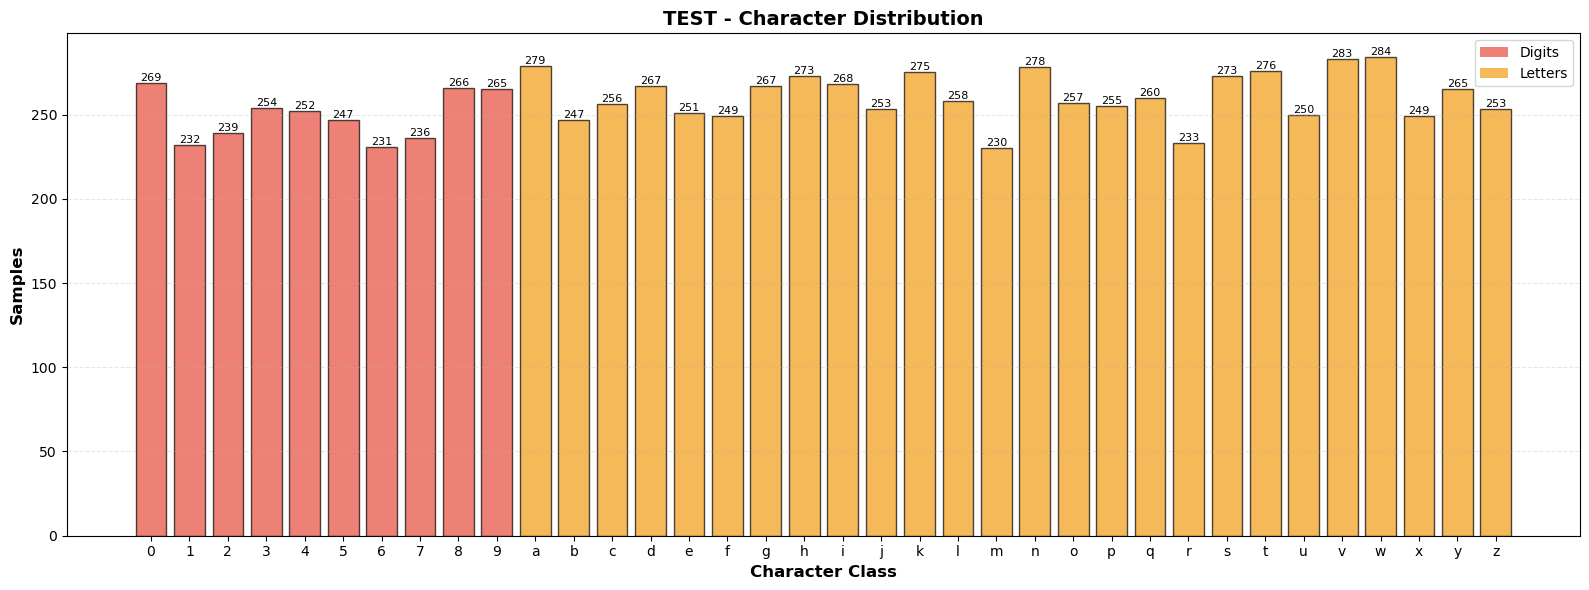

✓ Distribution charts displayed


In [28]:
# Visualize character distribution for all datasets
from matplotlib.patches import Patch

n_datasets = len(results)
fig, axes = plt.subplots(n_datasets, 1, figsize=(16, 6 * n_datasets))
if n_datasets == 1:
    axes = [axes]

colors_map = {'train': (['#3498db'] * 10 + ['#2ecc71'] * 26),
              'test': (['#e74c3c'] * 10 + ['#f39c12'] * 26)}

for idx, (name, res) in enumerate(results.items()):
    ax = axes[idx]
    sorted_counts = sorted(res['counters'].items(), key=lambda x: x[0])
    chars = [c[0] for c in sorted_counts]
    counts = [c[1] for c in sorted_counts]
    colors = colors_map.get(name, ['#95a5a6'] * 36)
    
    bars = ax.bar(chars, counts, color=colors, alpha=0.7, edgecolor='black')
    
    for bar, count in zip(bars, counts):
        if count > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{int(count)}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Character Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Samples', fontsize=12, fontweight='bold')
    ax.set_title(f'{name.upper()} - Character Distribution', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    legend_colors = ['#3498db', '#2ecc71'] if name == 'train' else ['#e74c3c', '#f39c12']
    legend = [Patch(facecolor=legend_colors[0], alpha=0.7, label='Digits'),
              Patch(facecolor=legend_colors[1], alpha=0.7, label='Letters')]
    ax.legend(handles=legend, loc='upper right')

plt.tight_layout()
plt.show()
print("✓ Distribution charts displayed")

## Sample Characters

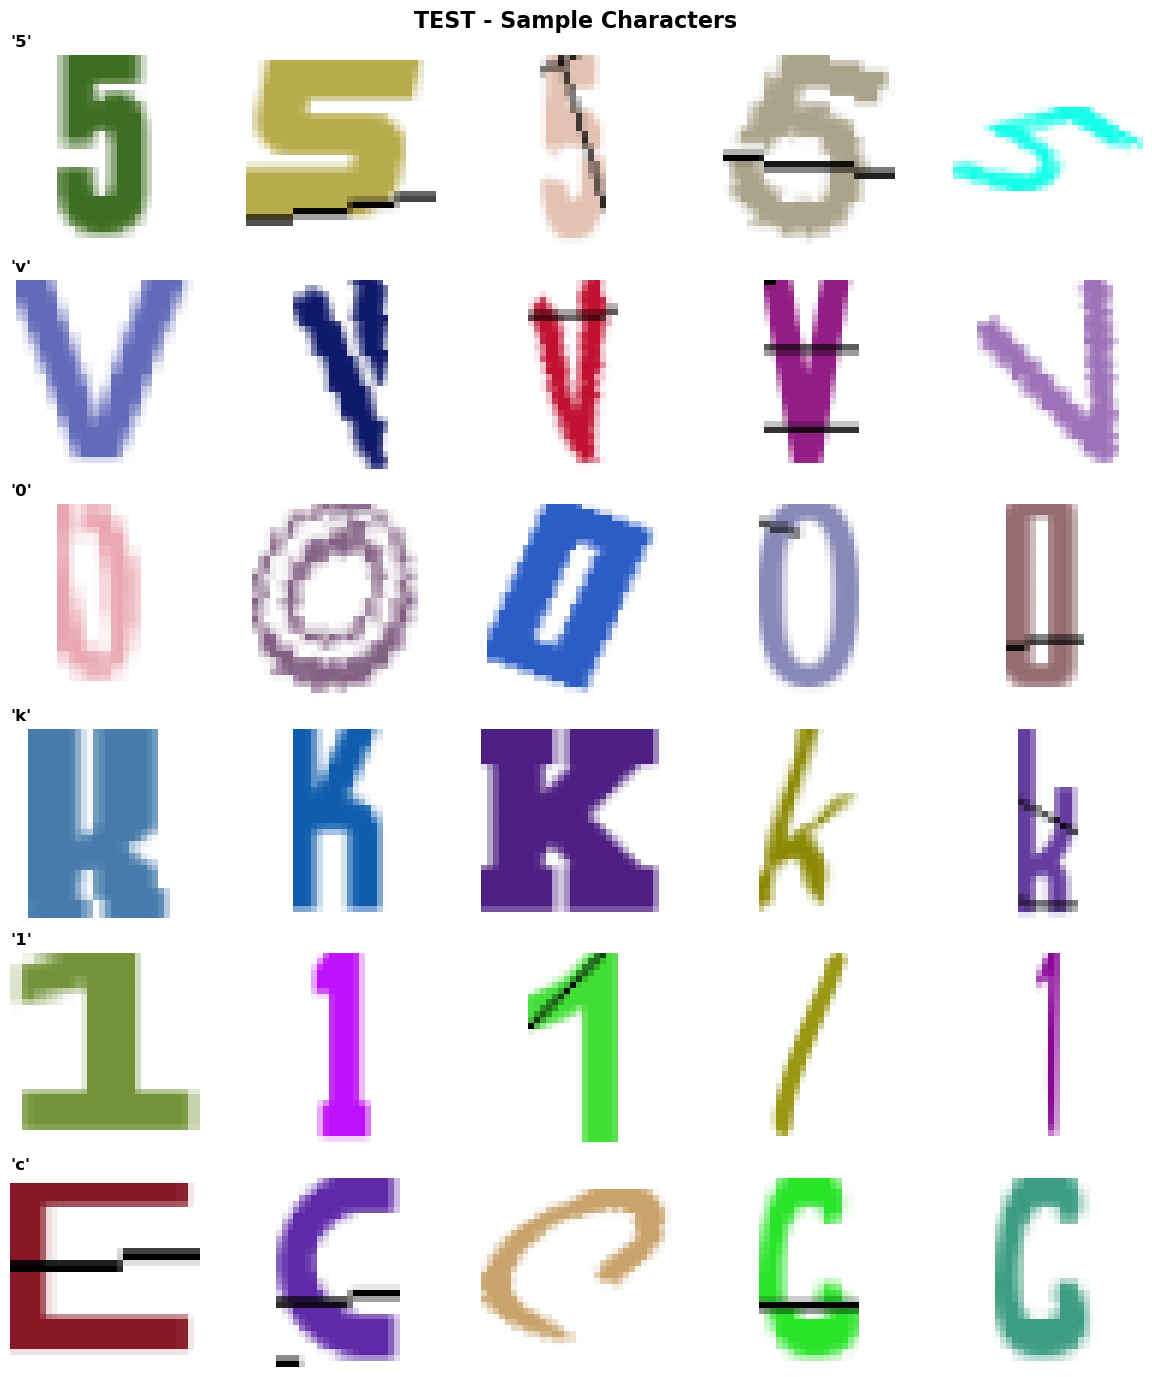

✓ Sample visualizations displayed


In [29]:
# Display sample characters from each dataset
import random

for name, res in results.items():
    output_dir = DATASETS[name]['output_dir']
    available = [c for c, cnt in res['counters'].items() if cnt > 0]
    sample_classes = random.sample(available, min(6, len(available)))
    
    fig, axes = plt.subplots(6, 5, figsize=(12, 14))
    fig.suptitle(f'{name.upper()} - Sample Characters', fontsize=16, fontweight='bold')
    
    for row, char_class in enumerate(sample_classes):
        images = list((output_dir / char_class).glob('*.png'))
        samples = random.sample(images, min(5, len(images)))
        
        for col, img_path in enumerate(samples):
            img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_title(f"'{char_class}'", fontsize=12, fontweight='bold', loc='left')
    
    plt.tight_layout()
    plt.show()

print("✓ Sample visualizations displayed")

## Error Report

In [30]:
# Display errors for each dataset
total_errors = sum(len(res['errors']) for res in results.values())

if total_errors > 0:
    for name, res in results.items():
        if res['errors']:
            print(f"\n{'='*70}")
            print(f"{name.upper()} - ERRORS ({len(res['errors'])} total)")
            print(f"{'='*70}")
            for i, err in enumerate(res['errors'][:20], 1):
                print(f"  {i}. {err}")
            if len(res['errors']) > 20:
                print(f"  ... and {len(res['errors']) - 20} more errors")
else:
    print("\n✓ No errors encountered!")


TEST - ERRORS (385 total)
  1. Mismatch: 04zqohgi-0.txt has 6 boxes but 8 chars
  2. Mismatch: 0a7sh2wp-0.txt has 7 boxes but 8 chars
  3. Mismatch: 0al4pl-0.txt has 7 boxes but 6 chars
  4. Mismatch: 0chnm34-0.txt has 3 boxes but 7 chars
  5. Mismatch: 0iqk95h-0.txt has 6 boxes but 7 chars
  6. Mismatch: 0k2lyyc-0.txt has 6 boxes but 7 chars
  7. Mismatch: 0lfjfob-0.txt has 3 boxes but 7 chars
  8. Mismatch: 0u0y5-0.txt has 0 boxes but 5 chars
  9. Mismatch: 0wcz1w-0.txt has 5 boxes but 6 chars
  10. Mismatch: 13bsgn2-0.txt has 5 boxes but 7 chars
  11. Mismatch: 153tt0-0.txt has 4 boxes but 6 chars
  12. Mismatch: 1ctc5l-0.txt has 3 boxes but 6 chars
  13. Mismatch: 1imwt-0.txt has 4 boxes but 5 chars
  14. Mismatch: 1irn-0.txt has 3 boxes but 4 chars
  15. Mismatch: 1rhud8rx-0.txt has 5 boxes but 8 chars
  16. Mismatch: 1sil9-0.txt has 4 boxes but 5 chars
  17. Mismatch: 1u81r-0.txt has 3 boxes but 5 chars
  18. Mismatch: 1wu0cul-0.txt has 6 boxes but 7 chars
  19. Mismatch: 1xut0w